**Implementation**

Imports

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cvxopt
cvxopt.solvers.options['show_progress'] = False

In [ ]:
SVM

In [ ]:
class custom_SVM(BaseEstimator, ClassifierMixin):
  def __init__(self, lr = 0.0001, K = 1000, iter = 1000):
    self.iter = iter
    self.lr = lr
    self.K = K
    self.w = None
    self.b = None

  def fit(self, X, y, plot_res = False):
    samples_n, features_n = X.shape
    self.w = np.zeros(features_n)
    self.b = 0
    for _ in range(self.iter):
      for i, x in enumerate(X):
        supp_vect = y[i]*(np.dot(self.w, x) - self.b) < 1

        if supp_vect:
          self.w -= self.lr*self.w - self.lr*self.K*y[i]*x
          self.b -= self.lr*self.K*y[i]
        else:
          self.w -= self.lr*self.w

    if plot_res:
      for i, x in enumerate(X):
        if y[i]*(np.dot(self.w, x) - self.b) < 0:
          print("supp")
      fig = plt.figure()
      ax = fig.add_subplot(projection='3d')
      for i, obs in enumerate(X):
        if y[i] == 1:
          ax.scatter(obs[0], obs[1], obs[2], color = "orange")
        else:
          ax.scatter(obs[0], obs[1], obs[2], color = "hotpink")
      x_range = np.linspace(-4, 0, 100)
      y_range = np.linspace(0, 4, 100)

      X, Y = np.meshgrid(x_range, y_range)

      Z = (self.b - self.w[0]*X - self.w[1]*Y)/(self.w[2]+0.00000001)

      ax.plot_surface(X, Y, Z, alpha=0.5)
      plt.show()


  def predict(self, X):
    return np.sign(np.dot(X,self.w) - self.b)

  def score(self, X, y):
        pred = self.predict(X)
        return sum(pred == y) / len(y)

In [ ]:
Multi Class SVM

In [ ]:
class multi_class_SVM(custom_SVM):
  def __init__(self, class_n, lr = 0.0001, K = 10000, iter = 1000):
    self.class_n = class_n
    self.iter = iter
    self.lr = lr
    self.K = K
    self.w = None
    self.b = None

  def fit(self, X, y, plot_res = False):
    samples_n, features_n = X.shape
    self.w = [[np.zeros(features_n)]*(k-1)for k in range(self.class_n,1,-1)]
    self.b = [[0]*(k-1)for k in range(self.class_n,1,-1)]
    for i in range(self.class_n):
      for j in range(self.class_n)[i+1:]:
        y_binary = np.where(y == i, 1, np.where(y == j, -1, 0))
        indices = np.where(y_binary != 0)[0]
        y_binary = y_binary[indices]
        X_binary = X[indices]
        for _ in range(self.iter):
          for ind, x in enumerate(X_binary):
            supp_vect = y_binary[ind]*(np.dot(self.w[i][j-i-1], x) - self.b[i][j-i-1]) < 1

            if supp_vect:
              self.w[i][j-i-1] -= self.lr*self.w[i][j-i-1] - self.lr*self.K*y_binary[ind]*x
              self.b[i][j-i-1] -= self.lr*self.K*y_binary[ind]
            else:
              self.w[i][j-i-1] -= self.lr*self.w[i][j-i-1]

        if plot_res:
          fig = plt.figure()
          ax = fig.add_subplot(projection='3d')
          ax.set_xlabel('GPA')
          ax.set_ylabel('Ales Score')
          ax.set_zlabel('Uni Score')
          categories = ["Accepted", "Rejected", "Interview"]
          ax.set_title(categories[i] + " vs. " + categories[j])
          for k, obs in enumerate(X_binary):
            if y_binary[k] == 1:
              ax.scatter(obs[plot_res[0]], obs[plot_res[1]], obs[plot_res[2]], color = "orange")
            else:
              ax.scatter(obs[plot_res[0]], obs[plot_res[1]], obs[plot_res[2]], color = "hotpink")
          x_range = np.linspace(-5, 5, 100)
          y_range = np.linspace(-5, 5, 100)

          X_ax, Y_ax = np.meshgrid(x_range, y_range)

          Z = (self.b[i][j-i-1] - self.w[i][j-i-1][plot_res[0]]*X_ax - self.w[i][j-i-1][plot_res[1]]*Y_ax)/(self.w[i][j-i-1][plot_res[2]]+0.000000001)

          ax.plot_surface(X_ax, Y_ax, Z, alpha=0.5)
          plt.show()

        """if plot_res:
          for feat1 in range(features_n-1):
            for feat2 in range(features_n-1)[feat1+1:]:
              for k, obs in enumerate(X_binary):
                if y_binary[k] == 1:
                  plt.scatter(obs[feat1], obs[feat2], color = "orange")
                else:
                  plt.scatter(obs[feat1], obs[feat2], color = "hotpink")
              x_range = np.linspace(-5, 5, 100)
              y_plot = (self.b[i][j-i-1] - self.w[i][j-i-1][feat1]*x_range)/self.w[i][j-i-1][feat2]
              plt.plot(x_range, y_plot)
              plt.show()"""

  def predict(self, X):
    final_results = []
    winners = []
    winner_dists = []
    for i in range(self.class_n):
      for j in range(self.class_n)[i+1:]:
        dist = np.dot(X,self.w[i][j-i-1]) - self.b[i][j-i-1]
        winners.append(np.where(dist > 0, i,j).tolist())
        winner_dists.append((np.sign(dist)*dist).tolist())
    winners = np.transpose(winners)
    winner_dists = np.transpose(winner_dists)

    for idx in range(len(winners)):
      occs = {}
      sums = {}
      for idguess in range(len(winners[idx])):
        if winners[idx][idguess] in occs:
            occs[winners[idx][idguess]] += 1
            sums[winners[idx][idguess]] += winner_dists[idx][idguess]
        else:
            occs[winners[idx][idguess]] = 1
            sums[winners[idx][idguess]] = winner_dists[idx][idguess]
      max_occurrence = max(occs.values())
      candidates = [key for key, count in occs.items() if count == max_occurrence]
      if len(candidates) > 1:
          max_sum = max(sums[key] for key in candidates)
          candidates = [key for key in candidates if sums[key] == max_sum]
      final_results.append(candidates[0])
    return final_results

  def score(self, X, y):
        pred = self.predict(X)
        return sum(pred == y) / len(y)





**Application**

Stage 1

In [ ]:
df = pd.read_excel("final_data492.xlsx", decimal=',')
df['n_of_applicants'] = df.groupby(['year', 'is_fall'])['year'].transform('count')

df_dropped = df.drop(columns=['interview_score', 'result_2', 'year', 'is_fall'])
X = df_dropped.drop(columns=['result_1'])
y = df_dropped['result_1'].values

X.drop(columns=['is_boun', 'is_ie'], inplace=True)


scaler = StandardScaler()
X = scaler.fit_transform(X)



mult_svm = multi_class_SVM(3, lr = 0.000001, K = 10000, iter = 1000)
cv_scores = cross_val_score(mult_svm, X, y, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate the mean accuracy
mean_accuracy = np.mean(cv_scores)
print("Mean accuracy:", mean_accuracy)



Cross-validation scores: [0.88785047 0.85981308 0.91509434 0.91509434 0.86792453]
Mean accuracy: 0.8891553517898079


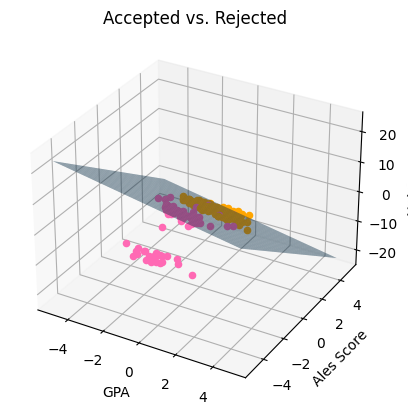

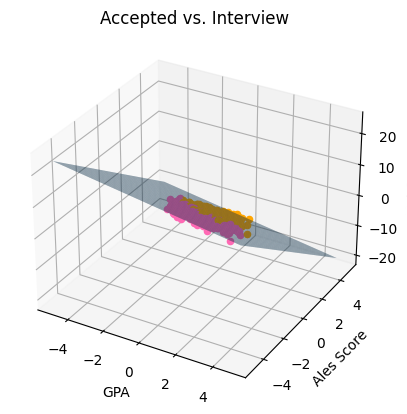

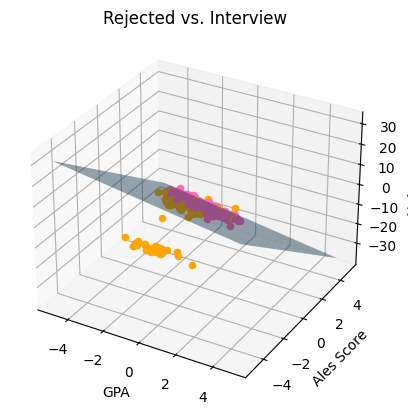

In [ ]:
mult_svm = multi_class_SVM(3, lr = 0.000001, K = 10000, iter = 1000)
mult_svm.fit(X,y, [0,1,2])

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
import numpy as np

df = pd.read_excel("final_data492.xlsx", decimal=',')
df['n_of_applicants'] = df.groupby(['year', 'is_fall'])['year'].transform('count')

df_dropped = df.drop(columns=['interview_score', 'result_2', 'year', 'is_fall'])
X = df_dropped.drop(columns=['result_1'])
y = df_dropped['result_1'].values

X.drop(columns=['is_boun', 'is_ie'], inplace=True)


scaler = StandardScaler()
X = scaler.fit_transform(X)


X_custom = X  # Your feature data
y_custom = y  # Your label data (0, 1, 2)

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear', C=1, decision_function_shape='ovr')

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm_classifier, X_custom, y_custom, cv=kf)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate the mean accuracy
mean_accuracy = np.mean(cv_scores)
print("Mean accuracy:", mean_accuracy)

Cross-validation scores: [0.89719626 0.90654206 0.8490566  0.85849057 0.95283019]
Mean accuracy: 0.8928231352495152


Stage 2

In [ ]:
df = pd.read_excel("final_data492.xlsx", decimal=',')
df['n_of_applicants'] = df.groupby(['year', 'is_fall'])['year'].transform('count')

df_interview = df[df["result_1"] == 2].copy()
df_interview.dropna(inplace=True)

df_interview.drop(columns=['result_1', 'year', 'is_fall', 'is_boun', 'is_ie'], inplace=True)

X = df_interview.drop(columns=['result_2']).values
y = df_interview['result_2'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=50)

kf = KFold(n_splits=5, shuffle=True, random_state=50)

svm = multi_class_SVM(2, lr = 0.000001, K = 10000, iter = 10000)
cv_scores = cross_val_score(svm, X_scaled, y, cv=5)

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.97916667 0.91666667 0.89583333 0.9375     0.8125    ]
Mean CV Score: 0.9083333333333332


In [ ]:
# Step 1: Read the data, specifying the decimal separator
df = pd.read_excel("final_data492.xlsx", decimal=',')
df['n_of_applicants'] = df.groupby(['year', 'is_fall'])['year'].transform('count')

# Step 2: Separate features and target variable
X = df.drop(columns=['result_1'])
y = df['result_1'].values

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Store the dropped columns and drop them from the training and testing sets
dropped_columns_train = X_train[['year', 'result_2', 'is_fall', 'interview_score']]
dropped_columns_test = X_test[['year', 'result_2', 'is_fall', 'interview_score']]

X_train.drop(columns=['year', 'result_2', 'is_fall', 'interview_score', 'is_boun', 'is_ie'], inplace=True)
X_test.drop(columns=['year', 'result_2', 'is_fall', 'interview_score', 'is_boun', 'is_ie'], inplace=True)

# Step 5: Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Fit the model, make predictions, and calculate the accuracy
svm = multi_class_SVM(3, lr = 0.000001, K = 10000, iter = 1000)
svm.fit(X_train_scaled, y_train)
pred = svm.predict(X_test_scaled)
accuracy = svm.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)

# Step 7: Merge predictions, actual labels, and features with dropped columns
results_df = pd.DataFrame({'Predicted_Result_1': pred, 'Actual_Result_1': y_test})
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)  # Convert X_test array to DataFrame
results_df = pd.concat([results_df, X_test_df.reset_index(drop=True), dropped_columns_test.reset_index(drop=True)], axis=1)

# Step 8: Concatenate with the original DataFrame
final_df = pd.concat([df, results_df], axis=1)

# Step 9: Save to Excel
final_df.to_excel('final_data_with_predictions.xlsx', index=False)


Accuracy: 0.8785046728971962


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        37
           1       0.73      0.53      0.62        15
           2       0.86      0.93      0.89        55

    accuracy                           0.88       107
   macro avg       0.85      0.80      0.82       107
weighted avg       0.87      0.88      0.87       107



In [ ]:
# Step 1: Read the data, specifying the decimal separator
df = pd.read_excel("final_data492.xlsx", decimal=',')
df['n_of_applicants'] = df.groupby(['year', 'is_fall'])['year'].transform('count')

df = df[df["result_1"] == 2].copy()
df.dropna(inplace=True)

# Step 2: Separate features and target variable
X = df.drop(columns=['result_2'])
y = df['result_2'].values

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

# Step 4: Store the dropped columns and drop them from the training and testing sets
dropped_columns_train = X_train[['year', 'result_1', 'is_fall']]
dropped_columns_test = X_test[['year', 'result_1', 'is_fall']]

X_train.drop(columns=['year', 'result_1', 'is_fall', 'is_boun', 'is_ie'], inplace=True)
X_test.drop(columns=['year', 'result_1', 'is_fall', 'is_boun', 'is_ie'], inplace=True)

# Step 5: Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Fit the model, make predictions, and calculate the accuracy
svm = multi_class_SVM(2, lr = 0.000001, K = 10000, iter = 10000)
svm.fit(X_train_scaled, y_train)
pred = svm.predict(X_test_scaled)
accuracy = svm.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)

# Step 7: Merge predictions, actual labels, and features with dropped columns
results_df = pd.DataFrame({'Predicted_Result_1': pred, 'Actual_Result_1': y_test})
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)  # Convert X_test array to DataFrame
results_df = pd.concat([results_df, X_test_df.reset_index(drop=True), dropped_columns_test.reset_index(drop=True)], axis=1)

# Step 8: Concatenate with the original DataFrame
final_df = pd.concat([df, results_df], axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

**Dual Implementation**

In [ ]:
class multi_class_SVM_dual(custom_SVM):
  def __init__(self, class_n, C = 10000):
    self.class_n = class_n
    self.C = C

  def fit(self, X, y, plot_res = False):
    samples_n, features_n = X.shape
    self.w = [[np.zeros(features_n)]*(k-1)for k in range(self.class_n,1,-1)]
    self.b = [[0]*(k-1)for k in range(self.class_n,1,-1)]
    for i in range(self.class_n):
      for j in range(self.class_n)[i+1:]:
        y_binary = np.where(y == i, 1, np.where(y == j, -1, 0))
        indices = np.where(y_binary != 0)[0]
        y_binary = y_binary[indices]
        X_binary = X[indices]
        n = len(y_binary)
        K = np.tile(y_binary, (4, 1)) * np.transpose(X_binary)
        P = cvxopt.matrix(np.dot(np.transpose(K), K))
        q = cvxopt.matrix(np.full(n, -1), (n, 1), "d")
        G = np.zeros((2 * n, n))
        np.fill_diagonal(G[:n, :], -1)
        np.fill_diagonal(G[n:, :], 1)
        G = cvxopt.matrix(G)
        h = np.zeros(2 * n)
        h[n:] = self.C
        h = cvxopt.matrix(h, (2*n, 1), "d")
        A = cvxopt.matrix(np.transpose(y_binary), (1, n),"d")
        b = cvxopt.matrix([0], (1, 1), "d")
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        lmbda = np.ravel(solution['x'])
        S = np.where((lmbda > 1e-10) & (lmbda <= self.C))[0]
        self.w[i][j-i-1] = K[:, S].dot(lmbda[S])
        M = np.where((lmbda > 1e-10) & (lmbda < self.C))[0]
        self.b[i][j-i-1] = np.mean(y[M] - X[M, :].dot(self.w[i][j-i-1]))



        if plot_res:
          fig = plt.figure()
          ax = fig.add_subplot(projection='3d')
          ax.set_xlabel('GPA')
          ax.set_ylabel('Ales Score')
          ax.set_zlabel('Uni Score')
          categories = ["Accepted", "Rejected", "Interview"]
          ax.set_title(categories[i] + " vs. " + categories[j])
          for k, obs in enumerate(X_binary):
            if y_binary[k] == 1:
              ax.scatter(obs[plot_res[0]], obs[plot_res[1]], obs[plot_res[2]], color = "orange")
            else:
              ax.scatter(obs[plot_res[0]], obs[plot_res[1]], obs[plot_res[2]], color = "hotpink")
          x_range = np.linspace(-5, 5, 100)
          y_range = np.linspace(-5, 5, 100)

          X_ax, Y_ax = np.meshgrid(x_range, y_range)

          Z = (self.b[i][j-i-1] - self.w[i][j-i-1][plot_res[0]]*X_ax - self.w[i][j-i-1][plot_res[1]]*Y_ax)/(self.w[i][j-i-1][plot_res[2]]+0.000000001)

          ax.plot_surface(X_ax, Y_ax, Z, alpha=0.5)
          plt.show()

        """if plot_res:
          for feat1 in range(features_n-1):
            for feat2 in range(features_n-1)[feat1+1:]:
              for k, obs in enumerate(X_binary):
                if y_binary[k] == 1:
                  plt.scatter(obs[feat1], obs[feat2], color = "orange")
                else:
                  plt.scatter(obs[feat1], obs[feat2], color = "hotpink")
              x_range = np.linspace(-5, 5, 100)
              y_plot = (self.b[i][j-i-1] - self.w[i][j-i-1][feat1]*x_range)/self.w[i][j-i-1][feat2]
              plt.plot(x_range, y_plot)
              plt.show()"""

  def predict(self, X):
    final_results = []
    winners = []
    winner_dists = []
    for i in range(self.class_n):
      for j in range(self.class_n)[i+1:]:
        dist = np.dot(X,self.w[i][j-i-1]) - self.b[i][j-i-1]
        winners.append(np.where(dist > 0, i,j).tolist())
        winner_dists.append((np.sign(dist)*dist).tolist())
    winners = np.transpose(winners)
    winner_dists = np.transpose(winner_dists)

    for idx in range(len(winners)):
      occs = {}
      sums = {}
      for idguess in range(len(winners[idx])):
        if winners[idx][idguess] in occs:
            occs[winners[idx][idguess]] += 1
            sums[winners[idx][idguess]] += winner_dists[idx][idguess]
        else:
            occs[winners[idx][idguess]] = 1
            sums[winners[idx][idguess]] = winner_dists[idx][idguess]
      max_occurrence = max(occs.values())
      candidates = [key for key, count in occs.items() if count == max_occurrence]
      if len(candidates) > 1:
          max_sum = max(sums[key] for key in candidates)
          candidates = [key for key in candidates if sums[key] == max_sum]
      final_results.append(candidates[0])
    return final_results

  def score(self, X, y):
        pred = self.predict(X)
        return sum(pred == y) / len(y)





NameError: name 'custom_SVM' is not defined

In [ ]:
df = pd.read_excel("final_data492.xlsx", decimal=',')
df['n_of_applicants'] = df.groupby(['year', 'is_fall'])['year'].transform('count')

df_dropped = df.drop(columns=['interview_score', 'result_2', 'year', 'is_fall'])
X = df_dropped.drop(columns=['result_1'])
y = df_dropped['result_1'].values

X.drop(columns=['is_boun', 'is_ie'], inplace=True)


scaler = StandardScaler()
X = scaler.fit_transform(X)

a = 0.2
best_acc = 0
best_a = 0
while a < 0.3:
  print("Current C =", a)
  mult_svm = multi_class_SVM_dual(3, C = a)
  cv_scores = cross_val_score(mult_svm, X, y, cv=5)  # 5-fold cross-validation

  # Print the cross-validation scores
  print("Cross-validation scores:", cv_scores)

  # Calculate the mean accuracy
  mean_accuracy = np.mean(cv_scores)
  print("Mean accuracy:", mean_accuracy)
  if mean_accuracy > best_acc:
    best_acc = mean_accuracy
    best_a = a
  best_acc = max(best_acc, mean_accuracy)
  print("Best mean accuracy:", best_acc, "for C =", best_a)

  a += 0.001
  print()


Current C = 0.2
Cross-validation scores: [0.8317757  0.81308411 0.86792453 0.89622642 0.76415094]
Mean accuracy: 0.834632339975313
Best mean accuracy: 0.834632339975313 for C = 0.2

Current C = 0.201
Cross-validation scores: [0.8317757  0.78504673 0.86792453 0.89622642 0.76415094]
Mean accuracy: 0.829024863339799
Best mean accuracy: 0.834632339975313 for C = 0.2

Current C = 0.202
Cross-validation scores: [0.85046729 0.76635514 0.86792453 0.88679245 0.76415094]
Mean accuracy: 0.8271380708869687
Best mean accuracy: 0.834632339975313 for C = 0.2

Current C = 0.203
Cross-validation scores: [0.85046729 0.76635514 0.86792453 0.88679245 0.76415094]
Mean accuracy: 0.8271380708869687
Best mean accuracy: 0.834632339975313 for C = 0.2

Current C = 0.20400000000000001
Cross-validation scores: [0.8411215  0.8317757  0.87735849 0.87735849 0.77358491]
Mean accuracy: 0.840239816610827
Best mean accuracy: 0.840239816610827 for C = 0.20400000000000001

Current C = 0.20500000000000002
Cross-validation s

In [ ]:
P = cvxopt.matrix([1,2,3,4],(2,2),"d")
q = cvxopt.matrix([-1,-1], (2, 1), "d")
G = np.zeros((2, 2))
np.fill_diagonal(G[:, :], 1)
G = cvxopt.matrix(G)
h = np.zeros(2)
h = cvxopt.matrix(h, (2, 1), "d")
A = cvxopt.matrix([-1, 1], (1, 2),"d")
b = cvxopt.matrix([0], (1, 1), "d")
solution = cvxopt.solvers.qp(P, q, G, h, A, b)
lmbda = np.ravel(solution['x'])
lmbda

array([-3.01558488e-09, -3.01558488e-09])

In [ ]:
X = np.matrix("4 1;3 5;5 2")
samples_n, features_n = X.shape
y = np.matrix("-1;1;1")
w = np.zeros(features_n)
b = 0
lr = 0.000001
K = 10000
iter = 1000
for _ in range(iter):
  for i, x in enumerate(X):
    supp_vect = y[i]*(np.dot(w, x) - b) < 1

    if supp_vect:
      w -= lr*w - lr*K*y[i]*x
      b -= lr*K*y[i]
    else:
      w -= lr*w

[0. 0.]
[[4 1]]


ValueError: shapes (2,) and (1,2) not aligned: 2 (dim 0) != 1 (dim 0)